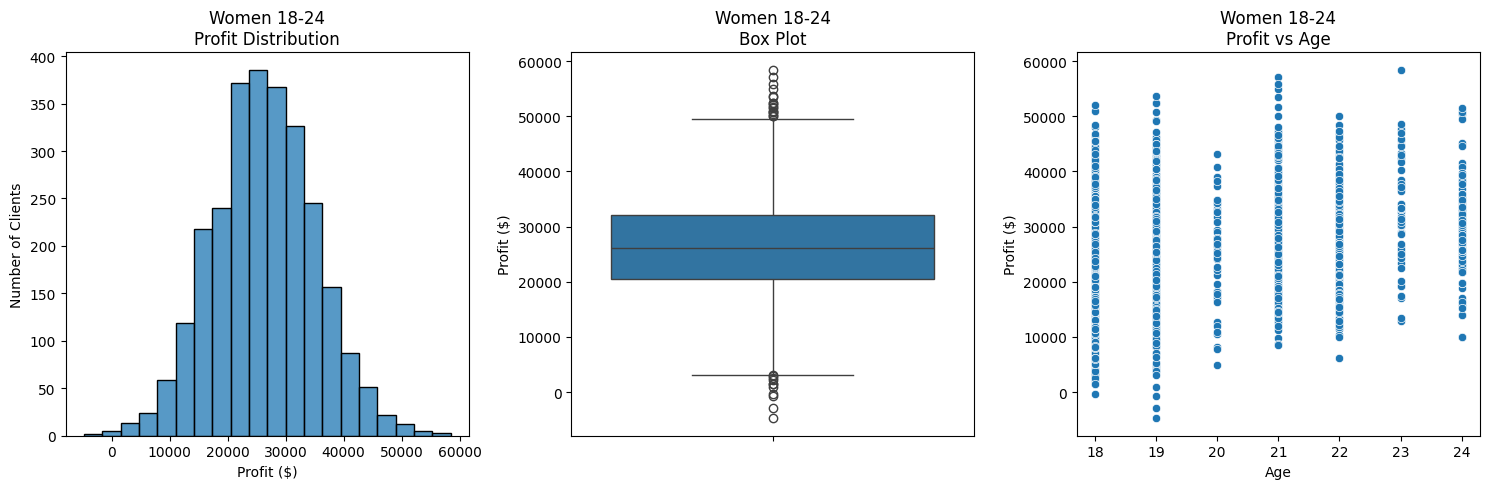

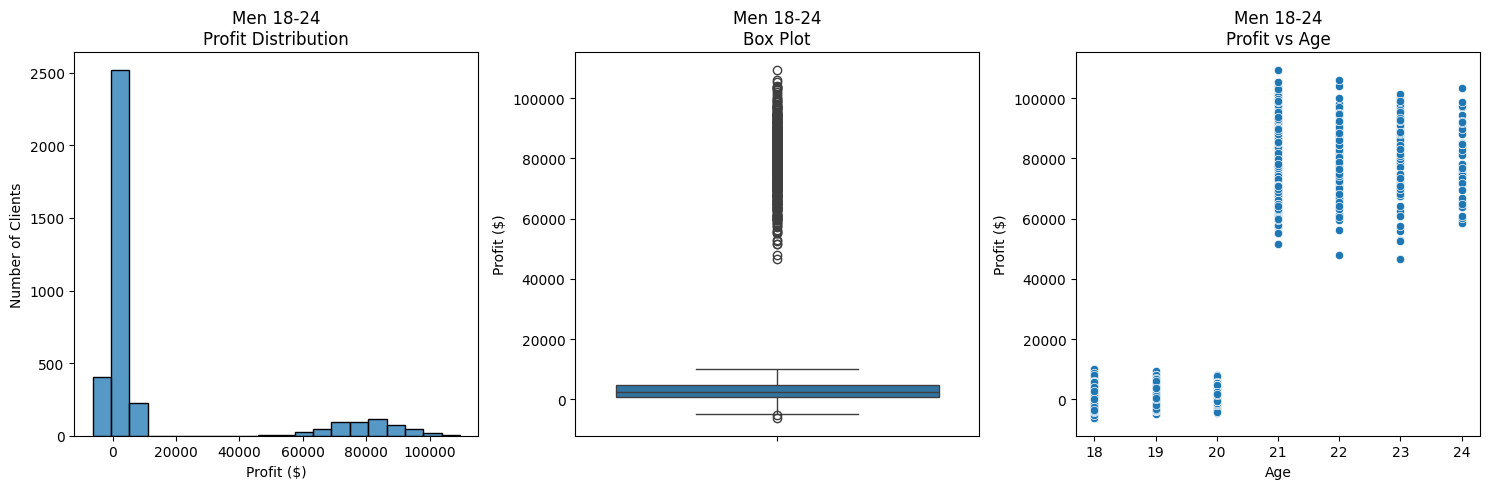

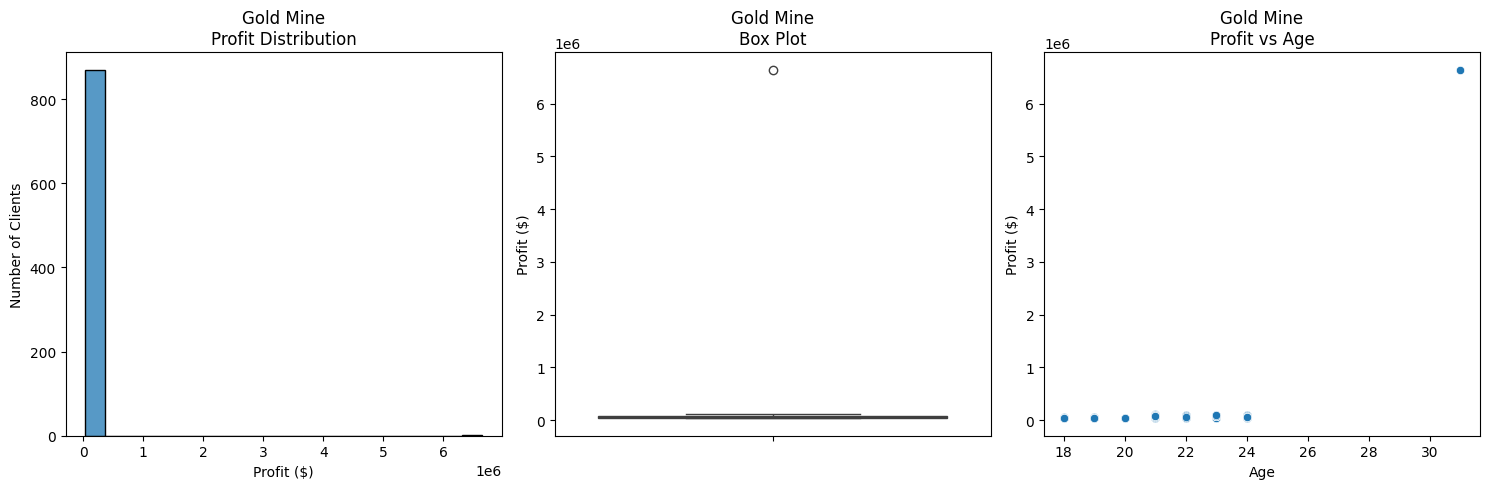

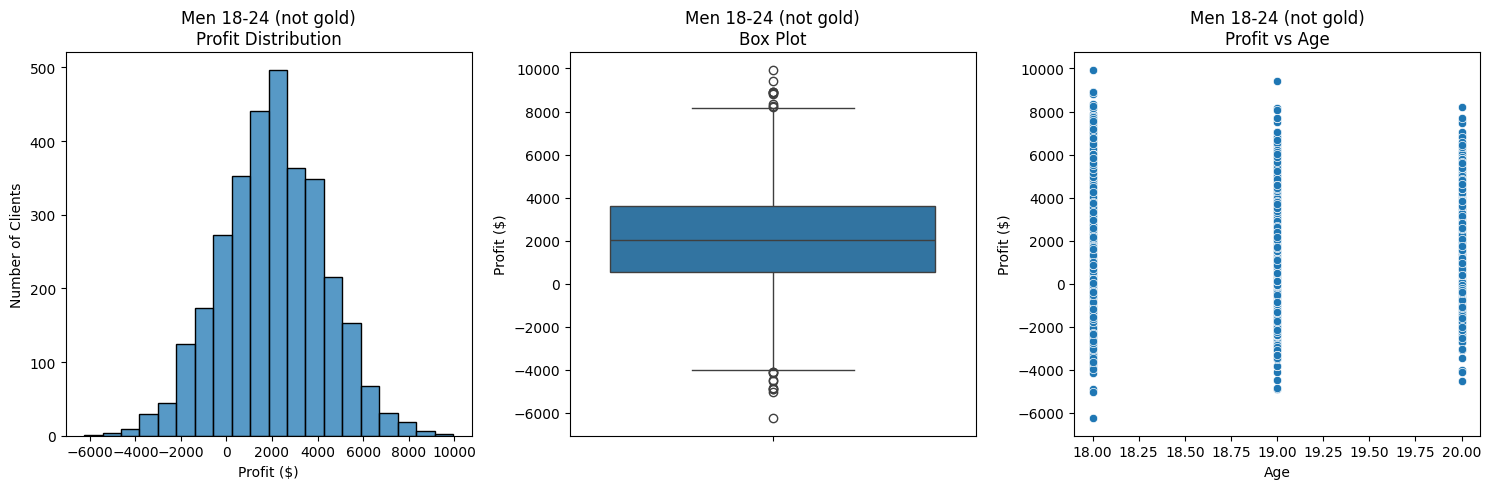

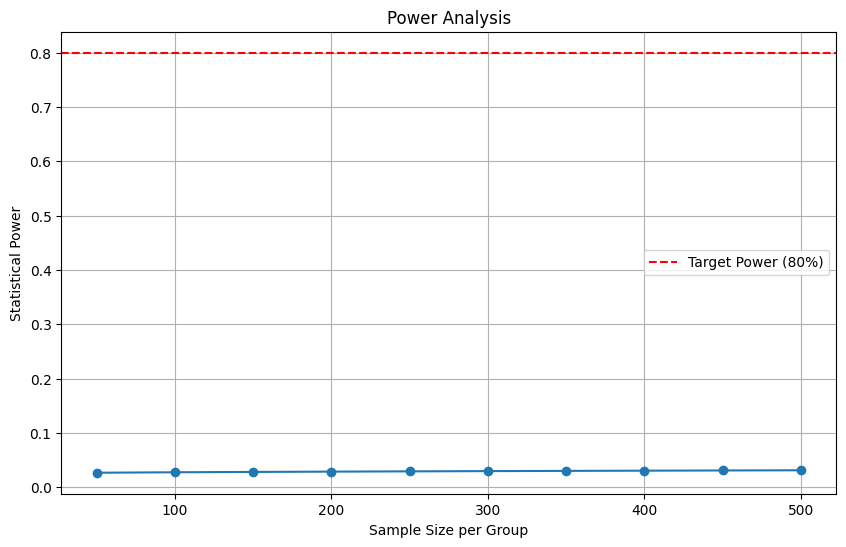

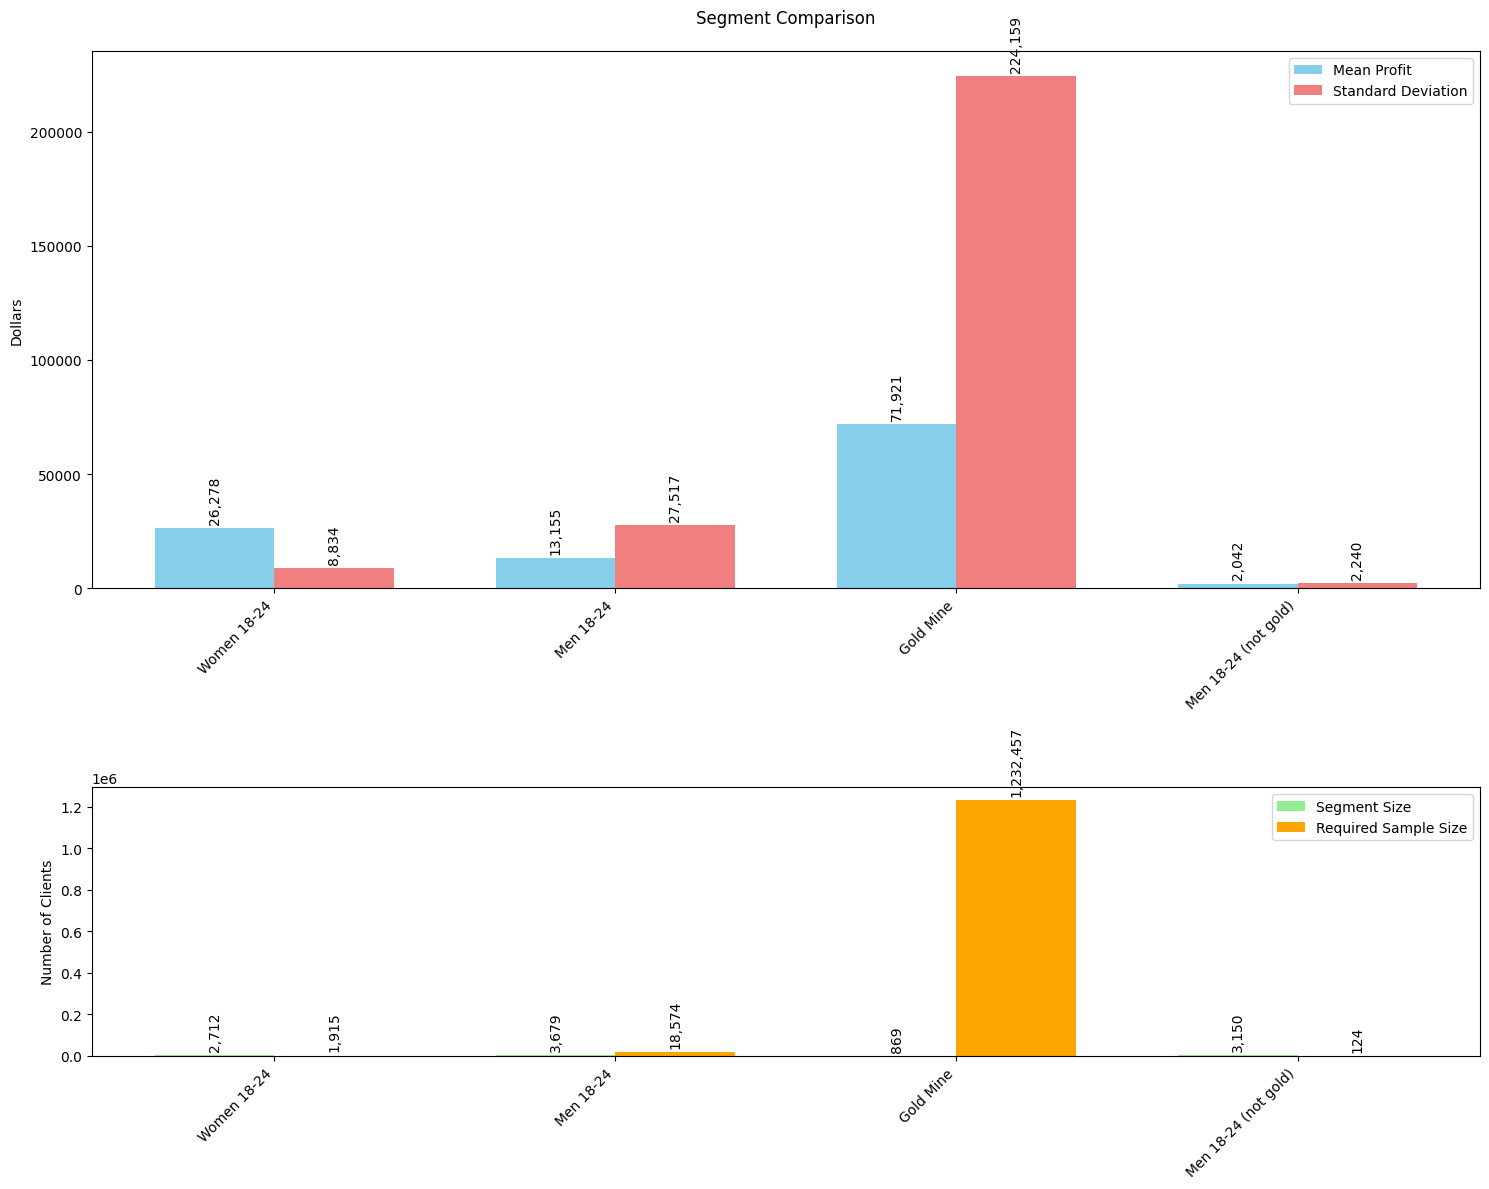

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import math

plt.rcParams['font.family'] = 'DejaVu Sans'

def calculate_sample_size(
    std_dev: float,
    effect_size: float = 800,
    alpha: float = 0.05,
    power: float = 0.80,
    ratio: float = 1.0
) -> Tuple[int, int]:
    d = effect_size / std_dev
    Z_alpha = stats.norm.ppf(1 - alpha/2)
    Z_beta = stats.norm.ppf(power)
    
    n2 = math.ceil((pow(Z_alpha + Z_beta, 2) * (1 + 1/ratio)) / pow(d, 2))
    n1 = math.ceil(n2 * ratio)
    
    return n1, n2

def analyze_category(data: pd.DataFrame, category_mask: pd.Series, category_name: str) -> dict:
    category_data = data[category_mask]
    
    profit_stats = {
        'mean': category_data['Profit'].mean(),
        'std': category_data['Profit'].std(),
        'count': len(category_data)
    }
    
    control_size, treatment_size = calculate_sample_size(
        std_dev=profit_stats['std'],
        effect_size=800,
        alpha=0.05,
        power=0.80
    )
    
    return {
        'category': category_name,
        'current_size': profit_stats['count'],
        'mean_profit': profit_stats['mean'],
        'standard_deviation': profit_stats['std'],
        'control_size': control_size,
        'test_size': treatment_size,
        'total_size': control_size + treatment_size
    }

def plot_profit_distribution(data: pd.DataFrame, category_mask: pd.Series, title: str):
    category_data = data[category_mask]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(data=category_data, x='Profit', bins=20)
    plt.title(f'{title}\nProfit Distribution')
    plt.xlabel('Profit ($)')
    plt.ylabel('Number of Clients')
    plt.subplot(1, 3, 2)
    sns.boxplot(data=category_data, y='Profit')
    plt.title(f'{title}\nBox Plot')
    plt.ylabel('Profit ($)')
    plt.subplot(1, 3, 3)
    sns.scatterplot(data=category_data, x='Age', y='Profit')
    plt.title(f'{title}\nProfit vs Age')
    plt.xlabel('Age')
    plt.ylabel('Profit ($)')
    
    plt.tight_layout()
    plt.show()

def main():
    df = pd.read_csv('https://raw.githubusercontent.com/zalig/cu-datasets/main/golden_mine.csv')
    df['Gender'] = df['Gender'].str.lower()
    women_18_24 = (df['Gender'] == 'female') & (df['AgeGroup'] == '18-24')
    men_18_24 = (df['Gender'] == 'male') & (df['AgeGroup'] == '18-24')
    gold_mine = df['Profit'] > df['Profit'].quantile(0.9)
    men_18_24_not_gold = men_18_24 & ~gold_mine
    
    categories = {
        'Women 18-24': women_18_24,
        'Men 18-24': men_18_24,
        'Gold Mine': gold_mine,
        'Men 18-24 (not gold)': men_18_24_not_gold
    }
    results = {}
    for category_name, category_mask in categories.items():
        results[category_name] = analyze_category(df, category_mask, category_name)
        plot_profit_distribution(df, category_mask, category_name)
    
    summary_df = pd.DataFrame(results).T
    sample_sizes = np.linspace(50, 500, 10, dtype=int)
    std_dev = df['Profit'].std()
    powers = [stats.norm.cdf(
        (np.sqrt(n/2) * 800 / std_dev) - stats.norm.ppf(0.975)
    ) for n in sample_sizes]
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, powers, marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target Power (80%)')
    plt.xlabel('Sample Size per Group')
    plt.ylabel('Statistical Power')
    plt.title('Power Analysis')
    plt.grid(True)
    plt.legend()
    plt.show()
    summary_df = pd.DataFrame(results).T
    plot_comparison(results)

def simulate_ab_test(
    current_data: pd.DataFrame,
    effect_size: float = 800,
    n_simulations: int = 1000
) -> dict:
    mean = current_data['Profit'].mean()
    std = current_data['Profit'].std()
    n1, n2 = calculate_sample_size(std)
    significant_tests = 0
    effect_detected = 0
    for _ in range(n_simulations):
        control = np.random.normal(mean, std, n1)
        treatment = np.random.normal(mean + effect_size, std, n2)
        
        t_stat, p_value = stats.ttest_ind(control, treatment)
        
        if p_value < 0.05:
            significant_tests += 1
            if t_stat > 0:
                effect_detected += 1
    return {
        'power': significant_tests / n_simulations,
        'correct_direction': effect_detected / n_simulations,
        'sample_size_per_group': n1
    }

def plot_comparison(results: dict):
    df = pd.DataFrame(results).T.reset_index()
    df.columns = ['Segment', 'category', 'current_size', 'mean_profit', 
                 'standard_deviation', 'control_size', 'test_size', 'total_size']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])
    x = np.arange(len(df['Segment']))
    width = 0.35
    bars1 = ax1.bar(x - width/2, df['mean_profit'], width, 
                    label='Mean Profit', color='skyblue')
    bars2 = ax1.bar(x + width/2, df['standard_deviation'], width, 
                    label='Standard Deviation', color='lightcoral')
    ax1.set_title('Segment Comparison', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['Segment'], rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylabel('Dollars')

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{int(height):,}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)
    
    autolabel(bars1)
    autolabel(bars2)
    
    bars3 = ax2.bar(x - width/2, df['current_size'], width, 
                    label='Segment Size', color='lightgreen')
    bars4 = ax2.bar(x + width/2, df['control_size'], width, 
                    label='Required Sample Size', color='orange')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['Segment'], rotation=45, ha='right')
    ax2.legend()
    ax2.set_ylabel('Number of Clients')
    
    def autolabel2(bars):
        for bar in bars:
            height = bar.get_height()
            ax2.annotate(f'{int(height):,}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)
    
    autolabel2(bars3)
    autolabel2(bars4)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# Presentation
https://docs.google.com/presentation/d/1o4aWxBEPihuwaDJHa58lGX9QeBHlq4vs1lrXwH-eMO0/edit?usp=sharing